# Music Recommendation System using Million Musical Tweets Dataset   
# and  Spotify Dataset


## Table of content
1. [Abstract](#Abstract)
2. [Basic analysis of MMTD](#Basic-analysis-of-MMTD)
3. [Basic analysis of Spotify dataset](#Basic-analysis-of-Spotify-dataset)
4. [KMeans clustering](#KMeans-clustering)
5. [Music recommendation](#Music-recommendation)

## Abstract
In this project, I created a music recommendation system. First, Million Musical Tweets and Spotify datasets are analyzed. Secondly, using the elbow method the proper number of clusters in the Spotify datasets was detected. In the next step one of the Twitter users was randomly picked. Her/His tweets were analyzed with respect to the songs she/he mentioned. The track, that appeared most often, was selected for the subsequent analysis. The features of this song were collected using the Spotify Web API. Later, using the variables, the cluster of the track was predicted. The prediction was made based on the kmeans clustering and the popularity of the songs (feature:'target'). Finally, the user was recommended 3 songs that she/he might like.

Data source:

-MMTD: http://www.cp.jku.at/datasets/MMTD/?fbclid=IwAR3dUeaJ2alrD_6OstK-wT4fykZbiATDiWoh1c_k3hx9NM-IPNwhbEw0b0o 
    
-Spotify datasets: https://github.com/fortyTwo102/The-Spotify-Hit-Predictor-Dataset 

Detailed description of the data from Spotify Web API can be found on the website: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-recommendations


## Basic analysis of MMTD
The data analysis is inspired by the article 'The million musical tweets dataset: what can we learn from microblogs' David Hauger, Andrej Kosir, Marko Tkalčič and Markus Schedl. Firstly I load the data and select the columns, which can be used in further analysis.

In [1]:
import numpy as np
import random
from sklearn.cluster import KMeans
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
import calendar
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# create spark seassion 
sc = SparkContext()
spark = SparkSession.builder.getOrCreate() 

# load the data
df_mmtd = spark.read.option("header", "true") \
    .option("delimiter", "\t") \
    .csv("mmtd.txt")

# select the columns of interest
df = df_mmtd.filter(df_mmtd.countryName!='NULL').select("tweet_id","tweet_userId", "artist_name", "track_title", "countryName", "tweet_longitude","tweet_latitude","continent","tweet_weekday","tweet_datetime")
df.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- tweet_userId: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_title: string (nullable = true)
 |-- countryName: string (nullable = true)
 |-- tweet_longitude: string (nullable = true)
 |-- tweet_latitude: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- tweet_weekday: string (nullable = true)
 |-- tweet_datetime: string (nullable = true)



### Number of tweets per day

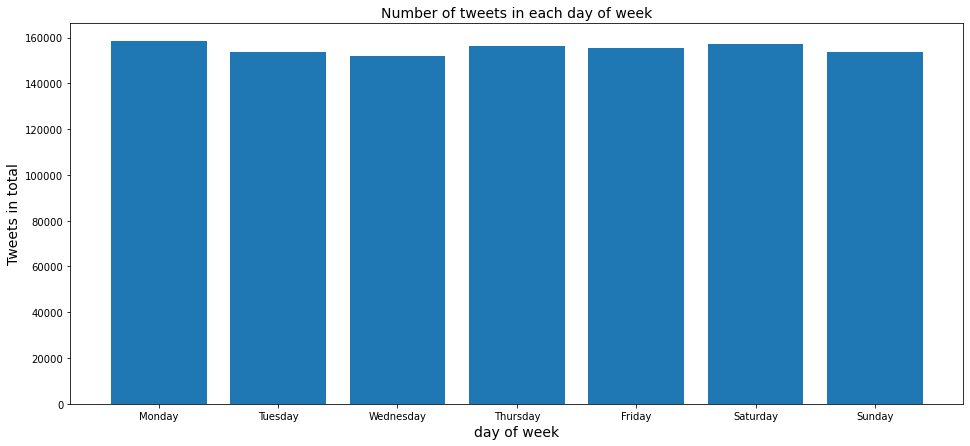

In [2]:
# Count how many times each week day appers in the dataset
week_days_count = df.groupBy("tweet_weekday").count().orderBy("tweet_weekday")
week_days_pd = week_days_count.toPandas()
week_count_val = list(week_days_pd["count"])

# change week days from intigers to name of the weekday
days = []
for i in list(week_days_pd["tweet_weekday"]): days.append(calendar.day_name[int(i)])
    
# plot the results
plt.figure(figsize=(16,7)) 
plt.bar(days,week_count_val)
plt.style.use('bmh')
plt.title('Number of tweets in each day of week', fontsize=14) 
plt.xlabel('day of week', fontsize=14) 
plt.ylabel('Tweets in total', fontsize=14) 
plt.show()

### Number of tweets in locations
I take into consideration 40 most popular locations. By most popular I mean the locations, where the largest number of tweets appeare. 

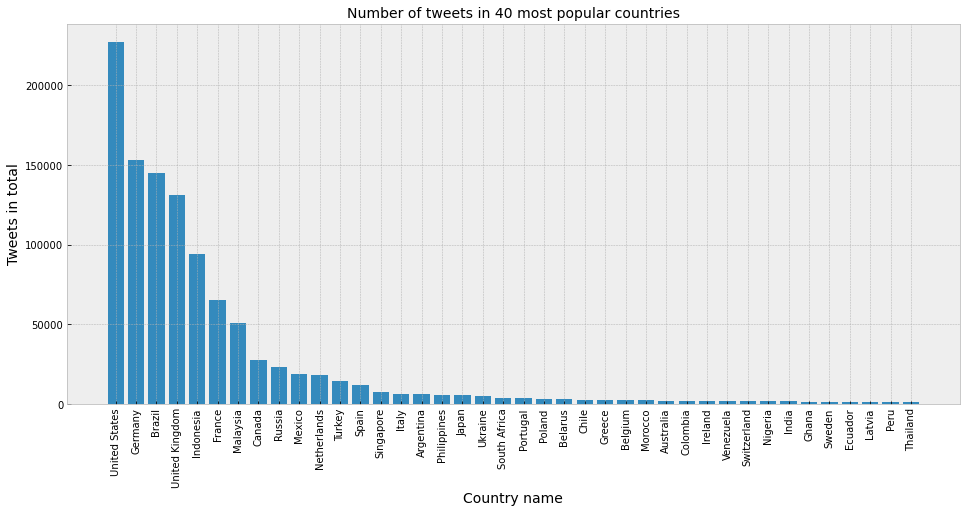

In [20]:
# Count how many tweets come from most popular locations 
location_count = df.groupBy("countryName").count().orderBy("countryName")
location_count = location_count.orderBy("count",ascending=False).limit(40)
location_count_pd = location_count.toPandas()

loc_count_val = list(location_count_pd["count"]) 
country = list(location_count_pd["countryName"]) 

# plot the result
plt.figure(figsize=(16,7)) 
plt.bar(country,loc_count_val)
plt.style.use('bmh')
plt.title('Number of tweets in 40 most popular countries', fontsize=14) 
plt.xlabel('Country name', fontsize=14) 
plt.xticks(rotation=90)
plt.ylabel('Tweets in total', fontsize=14) 
plt.show()

### Number of tweets in each hour
The column 'tweet_datetime' contains data in the format YYYY-MM-DD HH:MM:SS. In order to obtain the hour of posting the tweets I have to split this column. I assume that each time point between 1:00:00 AM and 1:59:59 AM is counted as 1 AM. 

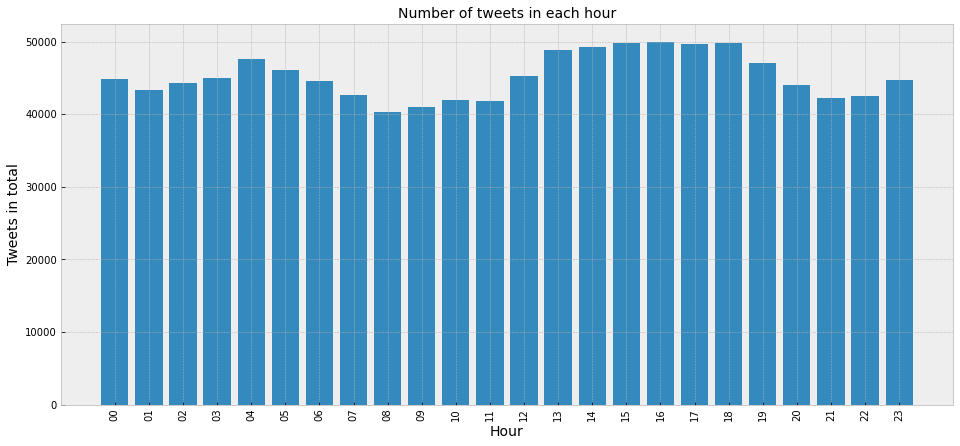

In [19]:
# get the time part of the column 'tweet_datetime' and then the hour part
df_with_hour = df.withColumn('time', F.split(df['tweet_datetime'], ' ').getItem(1)) 
df_with_hour = df_with_hour.withColumn('hour', F.split(df_with_hour['time'], ':').getItem(0)) 

# count how many times each hour appers
tweets_per_hour = df_with_hour.groupBy("hour").count().orderBy("hour")
tweets_per_hour = tweets_per_hour.toPandas()

week_count_val = list(tweets_per_hour["count"])
hours_list = [i for i in list(tweets_per_hour["hour"])]

# plot the results
plt.figure(figsize=(16,7))
plt.bar(hours_list,week_count_val)
plt.style.use('bmh')
plt.title('Number of tweets in each hour', fontsize=14) 
plt.xlabel('Hour', fontsize=14) 
plt.xticks(rotation=90)
plt.ylabel('Tweets in total', fontsize=14) 
plt.show()

### The most popular song in each country

In [22]:
#create temporary view 
songs_in_countries = df.select("countryName","artist_name","track_title").groupBy("countryName","artist_name","track_title").count()
songs_in_countries.createTempView("temp_view")

# get the most popular song in each country 
query = 'SELECT countryName, artist_name, track_title, count \
        FROM temp_view \
        WHERE count = ( \
           SELECT max(count) from temp_view i \
           WHERE i.countryName = temp_view.countryName) \
        ORDER BY count DESC'
most_pop_song_in_country = spark.sql(query)
most_pop_song_in_country.show(15)

+--------------+------------+--------------------+-----+
|   countryName| artist_name|         track_title|count|
+--------------+------------+--------------------+-----+
|       Germany|      Avicci|              Levels| 1427|
| United States|       Drake|            Practice| 1166|
|     Indonesia|       Adele|    Someone Like You| 1117|
|        Brazil|    Coldplay|            Paradise| 1078|
|United Kingdom|       Gotye|Somebody That I U...|  517|
|        France|     Rihanna|            Diamonds|  417|
|      Malaysia|      Judika|  Aku yang tersakiti|  264|
|   Netherlands|      Avicci|              Levels|  113|
|        Russia|    Coldplay|            Paradise|   78|
|        Turkey|      Plan B|            She Said|   70|
|        Mexico|       Adele|    Someone Like You|   62|
|        Canada|Van Morrison|              Domino|   49|
|         Spain|    Coldplay|            Paradise|   44|
|     Singapore|    Maroon 5|            Payphone|   39|
|   Philippines|       Adele|  

## Basic analysis of Spotify dataset
The spotify dataset is splitten into 6 .csv files. Each file corresponds to a decade. The data is from 1960s to 2010s. I focuse on the analysis of numerical features. All variables except 'key','loudness','tempo' are between 0 and 1, that is the reason why I normalized only selected features.

In [26]:
#load the data
spotify_songs_60 = pd.read_csv('Spotify\dataset-of-60s.csv')
spotify_songs_70 = pd.read_csv('Spotify\dataset-of-70s.csv')
spotify_songs_80 = pd.read_csv('Spotify\dataset-of-80s.csv')
spotify_songs_90 = pd.read_csv('Spotify\dataset-of-90s.csv')
spotify_songs_00 = pd.read_csv('Spotify\dataset-of-00s.csv')
spotify_songs_10 = pd.read_csv('Spotify\dataset-of-10s.csv')

#combine all dataframes into one 
spotify_songs = spotify_songs_00.append([spotify_songs_60, spotify_songs_70, spotify_songs_80,
                                        spotify_songs_90, spotify_songs_00, spotify_songs_10])
spotify_songs.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


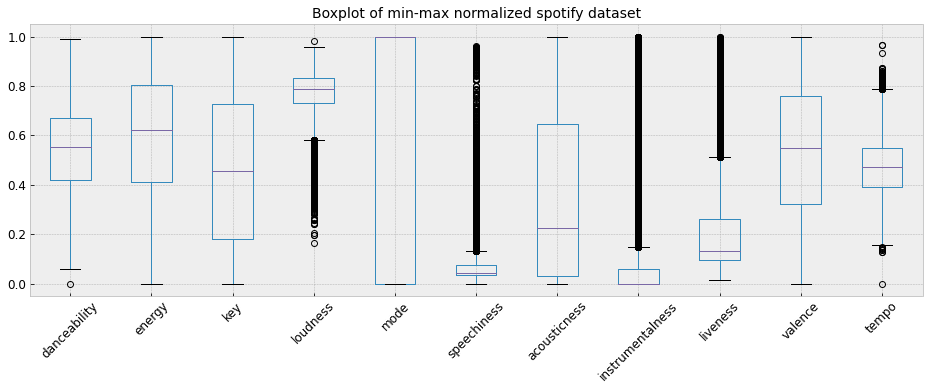

In [34]:
# select the numerical features
only_numeric_columns = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 
                        'liveness', 'valence', 'tempo', 'target']
numeric_spotify = spotify_songs[only_numeric_columns]

# min-max normalization
columns_need_to_be_normalized = ['key','loudness','tempo']
normalized_numeric_spotify = numeric_spotify[only_numeric_columns]
min_col = [0,-60,0]  #the min values for ['key','loudness','tempo']
max_col = [11,5,250] #the max values for ['key','loudness','tempo']
for i in range(len(columns_need_to_be_normalized)):
    label_name = columns_need_to_be_normalized[i]
    values_in_column = numeric_spotify[label_name]
    normalized_col = (values_in_column - min_col[i])/(max_col[i] - min_col[i])
    normalized_numeric_spotify[label_name] = normalized_col
    
# plot the boxplot
plt.figure(figsize=(16,5))
plt.title('Boxplot of min-max normalized spotify dataset', fontsize=14) 
boxplot = normalized_numeric_spotify.boxplot(column=only_numeric_columns[0:len(only_numeric_columns)-1],rot=45, fontsize=12)

From the boxplot we can see that the distributions of danceability, key and valence are almost symmetrical. The loudness, speechiness, instrumentalness and liveness have a lot of outliers, which may suggest that they are heavy-tailed distributed.
Note: target feature is not taking into consideration in boxplot, because it only takes two values (0 and 1) and boxplot in such a case does not make sense.

## KMeans clustering
I use k-means clustering on the Spotify dataset. In order to get the optimal number of clusters I use elbow method. Note: I don't use the target feature in the kmeans.

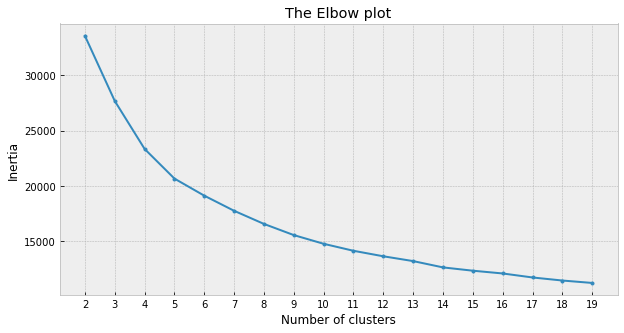

In [38]:
#elbow method
range_n_clusters = list(range(2,20))
inertia = []
for number_of_clusters in range_n_clusters:
    kmeanModel = KMeans(n_clusters=number_of_clusters)
    kmeanModel.fit(normalized_numeric_spotify)
    inertia.append(kmeanModel.inertia_)
    
#plot elbow method
plt.figure(figsize=(10,5))    
plt.plot(range_n_clusters,inertia,'.-')
plt.xticks(range_n_clusters)
plt.title("The Elbow plot")
plt.style.use('bmh')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [40]:
# get rid of target feature 
numeric_spotify_without_target = normalized_numeric_spotify[only_numeric_columns[0:len(only_numeric_columns)-1]]

# fit the kmeans
kmeans = KMeans(n_clusters=14).fit(numeric_spotify_without_target)

# predict and add new column with cluster labels to the data sets
predicted_clusters = kmeans.predict(numeric_spotify_without_target)
normalized_numeric_spotify['cluster'] = predicted_clusters
spotify_songs['cluster'] = predicted_clusters

## Music recommendation
In this section I randomly picke the tweeter user and predict songs, which she/he would like, base on the song she/he posted in Tweeter. The prediction is made based on the kmeans clustering.

In [52]:
# take all tweet users Id 
user_id = df.select("tweet_userId").distinct()
user_id_pd = user_id.toPandas()

# randomly pick one of them
user_id_list = [int(id) for id in user_id_pd["tweet_userId"]] 
random_user_id = random.choice(user_id_list)

#most often mentioned song by the user
random_user_song = df.groupBy("tweet_userId","artist_name","track_title").count().filter(df.tweet_userId == random_user_id).orderBy(F.col('count').desc()).limit(1)
random_user_song.show()
random_user_song_pd = random_user_song.toPandas()

+------------+-----------+-----------+-----+
|tweet_userId|artist_name|track_title|count|
+------------+-----------+-----------+-----+
|    75714770|  UVERworld| CORE PRIDE|    3|
+------------+-----------+-----------+-----+



In [54]:
# connect to Spotify Web API
client_id = 'client_id'
client_secret = 'client_secret'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#find features of interest for this song
random_user_song_list = random_user_song_pd.loc[0, :].values.tolist()
artists_name = random_user_song_list[1]
track_name = random_user_song_list[2]

try: # not all of the songs from MMTD are in spotify example Eva Simons 'This Is Love'
    searchResults = sp.search(q="artist:" + artists_name + " track:" + track_name, type="track")
    features = sp.audio_features(searchResults['tracks']['items'][0]['uri'])[0]
        
    features_dict = {}
    for i in only_numeric_columns[0:len(only_numeric_columns)-1]:
        features_dict[i] = features[i]
    
    # min-max normalization 
    for i in range(len(columns_need_to_be_normalized)):
        label_name = columns_need_to_be_normalized[i]
        values_in_column = features_dict[label_name]
        normalized_col = (values_in_column - min_col[i])/(max_col[i] - min_col[i])
        features_dict[label_name] = normalized_col    
    
except:
        print('There is no song ', artists_name, track_name, ' in Spotify. Try to select a new tweeter user.' )

In [57]:
# predict the cluster for this song
pred_clust_for_new_song = kmeans.predict(np.array(list(features_dict.values())).reshape(1, -1))

# find songs with the same cluster
songs_in_pred_cluster = spotify_songs.loc[(spotify_songs['cluster']==int(pred_clust_for_new_song) )&
                                          (spotify_songs['target'] == 1)]

# show 3 popular songs in this cluster
songs_in_pred_cluster.sample(n = 3)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,cluster
2058,That's A Rack,Lil Uzi Vert,spotify:track:4pCEIQ6wBVuaJdER5bALtO,0.852,0.432,1,-8.040,0,0.501,0.0599,0.000000,0.146,0.258,140.042,236571,4,27.47193,13,1,13
5831,Cupid Shuffle,Cupid,spotify:track:07Tx168RSsUS1HqkDIOZbH,0.785,0.582,5,-4.877,0,0.237,0.1910,0.000000,0.200,0.861,71.774,231360,4,47.51155,9,1,13
3057,MJB Da MVP,Mary J. Blige Featuring The Game & 50 Cent,spotify:track:4Ulh0OzG7AsYQif69JtIgS,0.745,0.739,1,-4.461,0,0.083,0.1310,0.000001,0.101,0.481,100.002,201213,4,19.87742,11,1,13


In [58]:
sc.stop()